In [1]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import os

In [2]:
dt_labels = pd.read_csv('./Dataset/Labels.csv')
print(dt_labels.head())
print(dt_labels.shape)

                image  label
0  Img/img001-001.png      0
1  Img/img001-002.png      0
2  Img/img001-003.png      0
3  Img/img001-004.png      0
4  Img/img001-005.png      0
(550, 2)


In [17]:
image_paths = dt_labels['image']
images = []
for filename in os.listdir("./Dataset/Img"):
    img = cv2.imread(os.path.join("./Dataset/Img",filename), 0)
    if img is not None:
        images.append(img)
print("Loaded all images!")
train_X = np.array(images)
train_X = train_X.reshape(550, 900 * 1200)
train_X = train_X.transpose()
train_X = tf.math.divide(train_X, 255)
print(train_X.shape)
print("All the training set it's ready")

Loaded all images!
(1080000, 550)
All the training set it's ready


In [14]:
def initialize_parameters(layers):
    initializerHe = tf.keras.initializers.HeNormal(seed=1)
    initializerGn = tf.keras.initializers.GlorotNormal(seed=1)
    
    for i in range(0, len(layers)-1):
        W1 = tf.Variable(initializerHe(shape=(5, 13)))
        b1 = tf.Variable(initializerHe(shape=(5, 1)))

    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

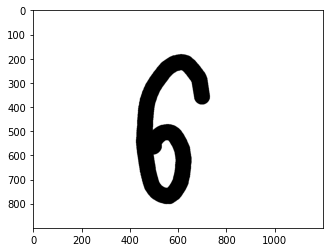

In [6]:
temp4 = train_X[:,346]
temp4 = temp4.reshape(900, 1200)
plt.gray()
plt.imshow(temp4)